<a href="https://colab.research.google.com/github/brijk20/2019-CS109B/blob/master/mach5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip "sample_data/resizedImg.zip" -d "testSet"

In [4]:
import os

In [5]:
print(os.getcwd())

/content


In [6]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

print(os.getcwd())

/content


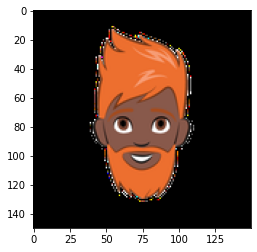

(150, 150, 3)


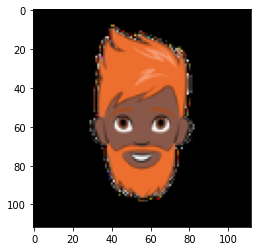

10000


In [19]:
DATADIR = "testSet/resizedImg"
path = DATADIR

for img in os.listdir(path):
    img_array = cv2.imread(os.path.join(path, img), 1)
    img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
    plt.imshow(img_array, cmap = 'gray')
    plt.show()
    break
#---------------------------------------------------------------------------------

print(img_array.shape)

#---------------------------------------------------------------------------------

IMG_SIZE = 112

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap = 'gray')
plt.show()

#---------------------------------------------------------------------------------

training_data = []

def create_training_data():
    
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img), 1)
        #img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        #img_array[:,:,2] = np.zeros([img_array.shape[0], img_array.shape[1]])
        new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
        
        training_data.append(new_array)

create_training_data()

#---------------------------------------------------------------------------------
print(len(training_data))

(112, 112, 3)


(-0.5, 111.5, 111.5, -0.5)

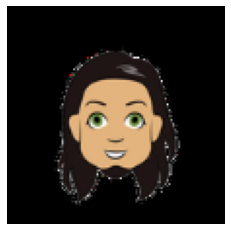

In [20]:
train_images = training_data

x = cv2.cvtColor(train_images[1230], cv2.COLOR_BGR2RGB)
print(x.shape)
plt.imshow(x)
plt.axis('off')

In [23]:
train_images = np.array(train_images).reshape(-1, 112,112,4)

#train_images = train_images.reshape(train_images.shape[0], 112, 112, 4).astype('float32') #BAS YAHI EK LINE --OK
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [24]:
import pickle

pickle_out = open("train_images.pickle", 'wb')
pickle.dump(train_images, pickle_out)
pickle_out.close()


In [ ]:
pickle_in = open("train_images.pickle", 'rb')
train_images = pickle.load(pickle_in)

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 256

In [ ]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Generator

In [33]:
# YAHA BHI MODIFY KARNA HE

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

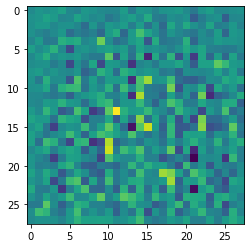

In [34]:
# YAHA BHI MODIFY KARNA HE
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

Discriminator

In [35]:
# YAHA BHI MODIFY KARNA HE
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [36]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00311316]], shape=(1, 1), dtype=float32)


In [32]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)